# <font color='#3e9dbf'>Import Library and Data</font>

In [1818]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix

In [1819]:
dataset = pd.read_csv('./customer_churn_data.csv')

# <font color='#3e9dbf'>Function</font>

## <font color='#e89c9a'><ul><li>Show Categorical</li></ul></font>

In [1820]:
def show_categorical_describe(attr_name, data=dataset):

  result_table = pd.DataFrame({
    '': ['Unique', 'Top', 'Frequency'],
    'Value': [
      len(data[attr_name].unique()), 
      data[attr_name].describe()['top'], 
      data[attr_name].describe()['freq'],
    ],
  })

  
  return result_table

In [1821]:
def show_categorical_values(attr_name, data=dataset):
  result_table = pd.DataFrame(
    [
      {
        'Name': value,
        'Total': data[attr_name].value_counts()[value],
        'Non-Churn': data[(data[attr_name] == value) & (data['Churn'] == 'No')].shape[0],
        'Churn': data[(data[attr_name] == value) & (data['Churn'] == 'Yes')].shape[0],
      }
      for value in data[attr_name].unique()
    ]
  )
  return result_table

## <font color='#e89c9a'><ul><li>Show Statistic values</li></ul></font>

In [1822]:
def showStatistics(attr_name, data=dataset, places=3):
  
  stats = data[attr_name].describe(percentiles=[.25, .5, .75])
  skewness = data[attr_name].skew()
  mode = data[attr_name].mode()[0]
  
  stats_table = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Mode', 'SD', 'Var', 'Min', 'Q₁', 'Q₂', 'Q₃', 'Max', 'Skew'],
    'Value': [
      round(stats['mean'], places),
      round(stats['50%'], places),
      round(mode, places),
      round(data[attr_name].std(), places),
      round(data[attr_name].var(), places),
      round(stats['min'], places),
      round(stats['25%'], places),
      round(stats['50%'], places),
      round(stats['75%'], places),
      round(stats['max'], places),
      round(skewness, places)
    ]
  })
  
  return stats_table

## <font color='#e89c9a'><ul><li>Plot Histograms with KDE</li></ul></font>

In [1823]:
def plot_hist_kde(attr_name, data=dataset):
  churn = data[data['Churn'] == 'Yes'][attr_name]
  non_churn = data[data['Churn'] == 'No'][attr_name]

  plt.figure(figsize=(8, 5))
  sns.histplot(churn, color='#ad4000', label='Churn', kde=True)
  sns.histplot(non_churn, color='#006dad', label='Non-Churn', kde=True)
  
  plt.xlabel(attr_name, fontsize=14)
  plt.ylabel('Frequency', fontsize=14)

  plt.legend(frameon=False, fontsize=16, bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
  plt.gca().set_facecolor("none")
  plt.gcf().set_facecolor("none")
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.gca().ticklabel_format(axis='x', style='sci', scilimits=(-3,3))
  plt.show()

## <font color='#e89c9a'><ul><li>Plot Boxplot</li></ul></font>

In [1824]:
def plot_boxplot(attr_name, data=dataset):
  ax = sns.boxplot(data=data[attr_name], color='#006dad')
  ax.set_facecolor("none")

  ax.spines['top'].set_color('#4c4b49')
  ax.spines['right'].set_color('#4c4b49')
  ax.spines['left'].set_color('#4c4b49')
  ax.spines['bottom'].set_color('#4c4b49')

  ax.tick_params(axis='both', colors='#4c4b49')
  plt.gcf().set_facecolor("none")
  plt.show()

  Q1 = data[attr_name].quantile(0.25)
  Q3 = data[attr_name].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  bounds_table = pd.DataFrame({
    'Statistic': ['Q₁', 'Q₃', 'IQR', 'Lower Bound', 'Upper Bound'],
    'Value': [Q1, Q3, IQR, lower_bound, upper_bound]
  })

  return bounds_table

## <font color='#e89c9a'><ul><li>Plot Comparison Boxplot</li></ul></font>

In [1825]:
def plot_comparison_boxplot(attr_name, data=dataset):
  
  title = ' '.join([word.capitalize() for word in attr_name.split()])
  palette = {'No': '#006dad', 'Yes': '#ad4000'}

  plt.figure(figsize=(6, 7))
  sns.boxplot(x='Churn', y=attr_name, hue='Churn', data=data, palette=palette, dodge=False, legend=False).set_facecolor("none")
  plt.xlabel('Churn', fontsize=16)
  plt.ylabel(title, fontsize=16)
  plt.gcf().set_facecolor("none")
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
  plt.legend(frameon=False, fontsize=16, labels=['Non-Churn', 'Churn'], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
  plt.show()

  stats_list = []

  for class_name, group in data.groupby('Churn'):
    stats = {
      'Class': 'Non-Churn' if class_name == 'No' else 'Churn',
      'Q₁': round(group[attr_name].quantile(.25), 5),
      'Q₃': round(group[attr_name].quantile(.75), 5),
    }
    stats_list.append(stats)

  return pd.DataFrame(stats_list)


## <font color='#e89c9a'><ul><li>Plot Confusion Matrix</li></ul></font>

In [1826]:
def plot_confusion_matrix(cm, color='blue'):

	classes = ['Non-Churn', 'Churn']
	cmap = plt.cm.Blues if color == 'blue' else plt.cm.Oranges
	norm = plt.Normalize(vmin=cm.min(), vmax=cm.max())  # normalization แบบเดียวกับ imshow

	plt.figure(figsize=(10, 10))
	plt.imshow(cm, interpolation='nearest', cmap=cmap, norm=norm)
	plt.colorbar(aspect=4)

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, size=18)
	plt.yticks(tick_marks, classes, size=18)

	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		# ใช้ colormap กับค่าที่ normalize แล้ว
		rgba = cmap(norm(cm[i, j]))
		r, g, b = rgba[:3]
		luminance = 0.299 * r + 0.587 * g + 0.114 * b

		text_color = 'black' if luminance > 0.5 else 'white'
		plt.text(j, i, format(cm[i, j], 'd'), fontsize=30, horizontalalignment="center", color=text_color)

	plt.gca().set_facecolor('none')
	plt.grid(False)
	plt.tight_layout()
	plt.ylabel('Actual', size=16)
	plt.xlabel('Predicted', size=16, labelpad=20)

	plt.show()

## <font color='#e89c9a'><ul><li>Plot Learning Curve</li></ul></font>

In [1827]:
def plot_learning_curve(model, x, y):
	cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

	train_sizes, train_scores, val_scores = learning_curve(
		model, x, y, cv=cv, scoring='accuracy',
		train_sizes=np.linspace(0.1, 1.0, 10)
	)

	train_scores_mean = np.mean(train_scores, axis=1)
	val_scores_mean = np.mean(val_scores, axis=1)

	plt.figure(figsize=(10, 7))
	plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
	plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
	plt.xlabel("Training Examples", fontsize=16)
	plt.ylabel("Accuracy", fontsize=16)
	plt.xticks(fontsize=18)
	plt.yticks(fontsize=18)
	plt.legend(fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
	plt.grid(True)
	plt.show()

# <font color='#3e9dbf'>Dataset Info</font>

In [1828]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5880 non-null   object 
 1   gender            5880 non-null   object 
 2   SeniorCitizen     5880 non-null   int64  
 3   Partner           5880 non-null   object 
 4   Dependents        5880 non-null   object 
 5   tenure            5880 non-null   int64  
 6   PhoneService      5880 non-null   object 
 7   MultipleLines     5880 non-null   object 
 8   InternetService   5880 non-null   object 
 9   OnlineSecurity    5880 non-null   object 
 10  OnlineBackup      5880 non-null   object 
 11  DeviceProtection  5880 non-null   object 
 12  TechSupport       5880 non-null   object 
 13  StreamingTV       5880 non-null   object 
 14  StreamingMovies   5880 non-null   object 
 15  Contract          5880 non-null   object 
 16  PaperlessBilling  5880 non-null   object 


In [1829]:
dataset.head(len(dataset))

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST0000,Male,0,No,Yes,23,No,No phone service,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer,49.85,1146.55,No
1,CUST0001,Female,0,Yes,No,43,No,No phone service,DSL,Yes,...,Yes,No,Yes,No,Month-to-month,No,Mailed check,100.70,4330.10,Yes
2,CUST0002,Male,1,No,No,51,Yes,No,DSL,No,...,Yes,Yes,No,No,One year,No,Electronic check,97.33,4963.83,Yes
3,CUST0003,Male,1,No,No,72,Yes,Yes,DSL,Yes,...,Yes,No,No,No,Month-to-month,No,Credit card,101.38,7299.36,No
4,CUST0004,Male,1,No,No,25,Yes,Yes,DSL,No,...,No,Yes,No,Yes,Month-to-month,No,Electronic check,52.22,1305.50,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5875,CUST5875,Male,0,Yes,Yes,71,Yes,No,DSL,Yes,...,No,Yes,No,No,Month-to-month,Yes,Mailed check,74.21,5268.91,No
5876,CUST5876,Male,0,No,No,22,Yes,Yes,DSL,No,...,Yes,Yes,No,Yes,One year,No,Mailed check,65.43,1439.46,Yes
5877,CUST5877,Female,0,No,No,68,No,No phone service,Fiber optic,Yes,...,Yes,Yes,Yes,No,One year,Yes,Bank transfer,59.78,4065.04,No
5878,CUST5878,Female,0,Yes,Yes,14,No,No phone service,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Mailed check,91.88,1286.32,No


# <font color='#3e9dbf'>Feature</font>

## <font color='#e89c9a'><ul><li>Target</li></ul></font>

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Churn</li></ul></font>

In [1830]:
attr_name = 'Churn'

In [1831]:
show_categorical_describe(attr_name)

,,Value
0,Unique,2
1,Top,No
2,Frequency,2982


In [1832]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,No,2982,2982,0
1,Yes,2898,0,2898


## <font color='#e89c9a'><ul><li>Identifier</li></ul></font>

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Customer ID</li></ul></font>

In [1833]:
attr_name = 'customerID'

dataset[attr_name].describe()

count         5880
unique        5880
top       CUST5879
freq             1
Name: customerID, dtype: object

In [1834]:
dataset[attr_name].head(len(dataset))

0       CUST0000
1       CUST0001
2       CUST0002
3       CUST0003
4       CUST0004
          ...   
5875    CUST5875
5876    CUST5876
5877    CUST5877
5878    CUST5878
5879    CUST5879
Name: customerID, Length: 5880, dtype: object

## <font color='#e89c9a'><ul><li>Numerical</li></ul></font>

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Tenure</li></ul></font>

In [1835]:
attr_name = 'tenure'

In [1836]:
showStatistics(attr_name)

,Statistic,Value
0,Mean,36.549
1,Median,37.000
2,Mode,15.000
3,SD,20.910
4,Var,437.214
5,Min,1.000
6,Q₁,18.000
7,Q₂,37.000
8,Q₃,55.000
9,Max,72.000


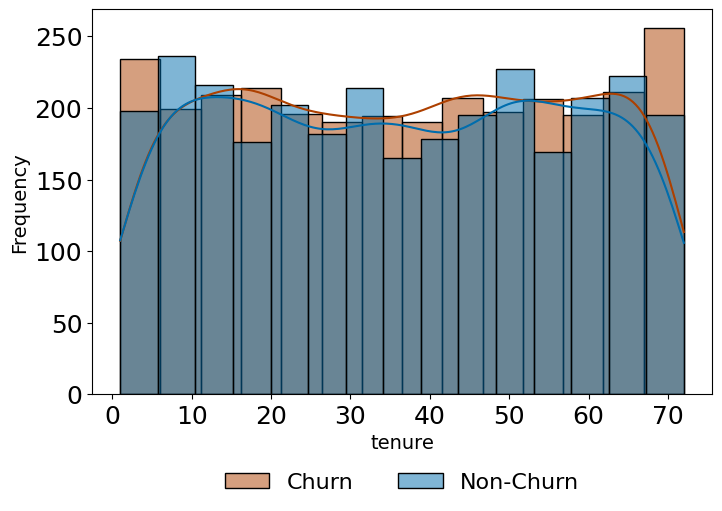

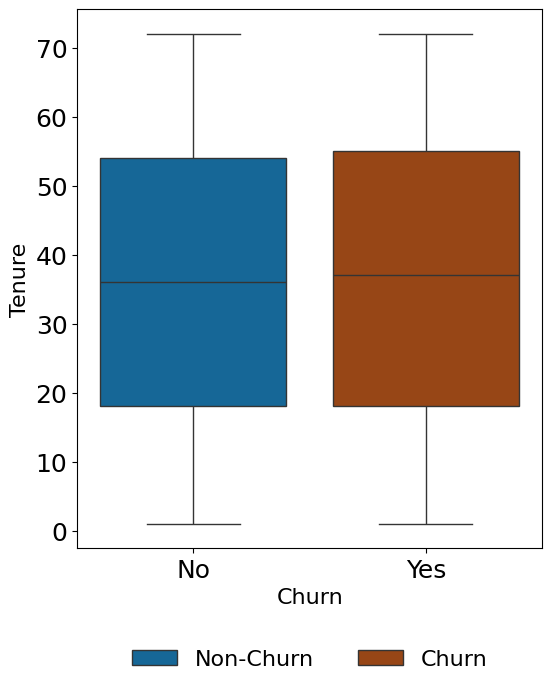

,Class,Q₁,Q₃
0,Non-Churn,18.0,54.0
1,Churn,18.0,55.0


In [1837]:
plot_hist_kde(attr_name)
plot_comparison_boxplot(attr_name)

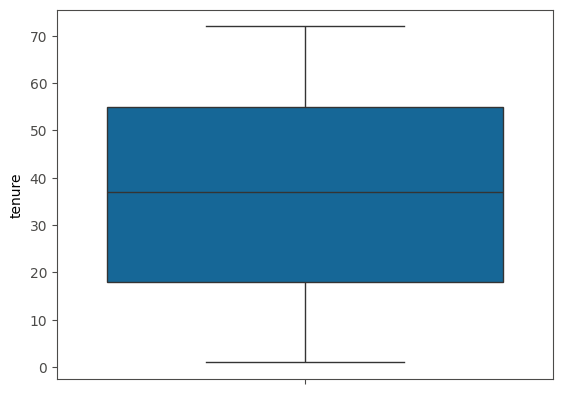

,Statistic,Value
0,Q₁,18.0
1,Q₃,55.0
2,IQR,37.0
3,Lower Bound,-37.5
4,Upper Bound,110.5


In [1838]:
plot_boxplot(attr_name)

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Monthly Charges</li></ul></font>

In [1839]:
attr_name = 'MonthlyCharges'

In [1840]:
showStatistics(attr_name)

,Statistic,Value
0,Mean,70.158
1,Median,70.155
2,Mode,65.130
3,SD,28.805
4,Var,829.706
5,Min,20.000
6,Q₁,45.718
7,Q₂,70.155
8,Q₃,95.458
9,Max,119.990


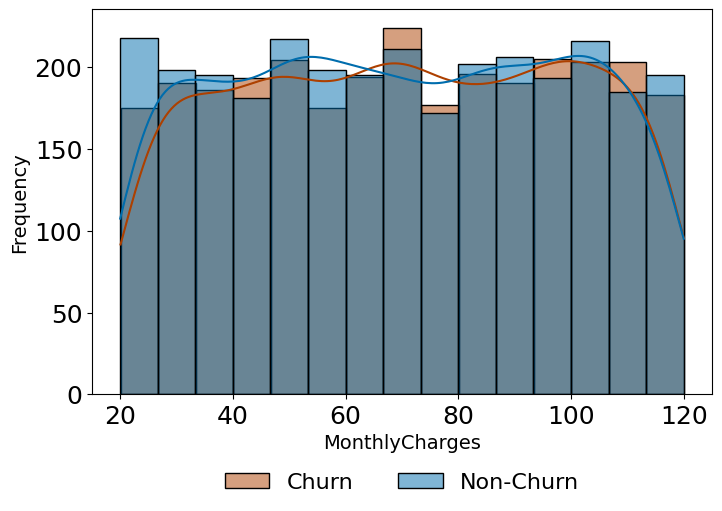

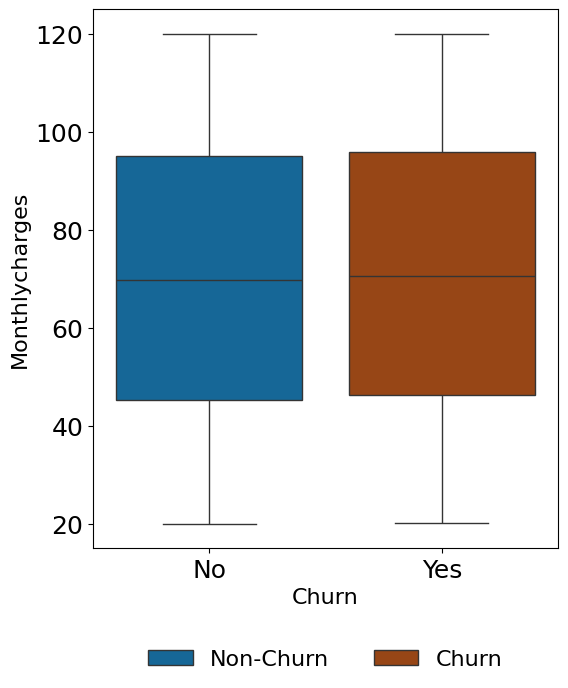

,Class,Q₁,Q₃
0,Non-Churn,45.1825,95.0775
1,Churn,46.2300,95.7875


In [1841]:
plot_hist_kde(attr_name)
plot_comparison_boxplot(attr_name)

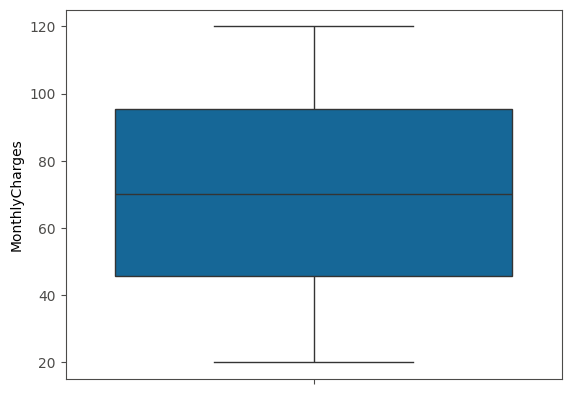

,Statistic,Value
0,Q₁,45.7175
1,Q₃,95.4575
2,IQR,49.7400
3,Lower Bound,-28.8925
4,Upper Bound,170.0675


In [1842]:
plot_boxplot(attr_name)

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Total Charges</li></ul></font>

In [1843]:
attr_name = 'TotalCharges'

In [1844]:
showStatistics(attr_name)

,Statistic,Value
0,Mean,2566.813
1,Median,2136.445
2,Mode,635.040
3,SD,1910.018
4,Var,3648167.777
5,Min,20.030
6,Q₁,1020.218
7,Q₂,2136.445
8,Q₃,3767.665
9,Max,8589.600


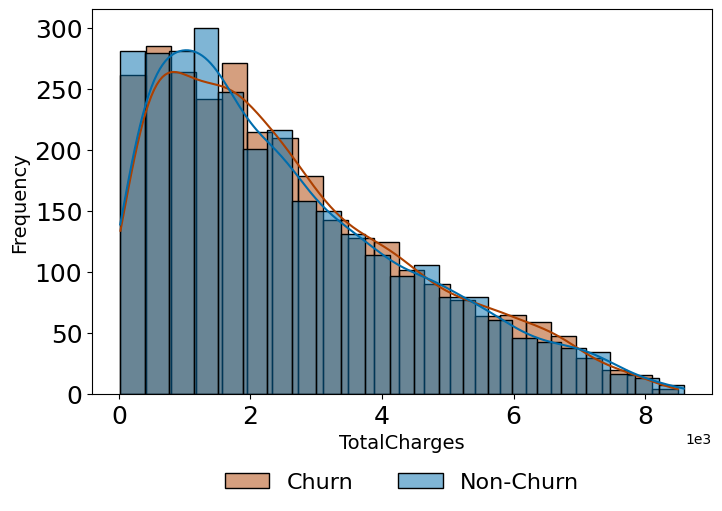

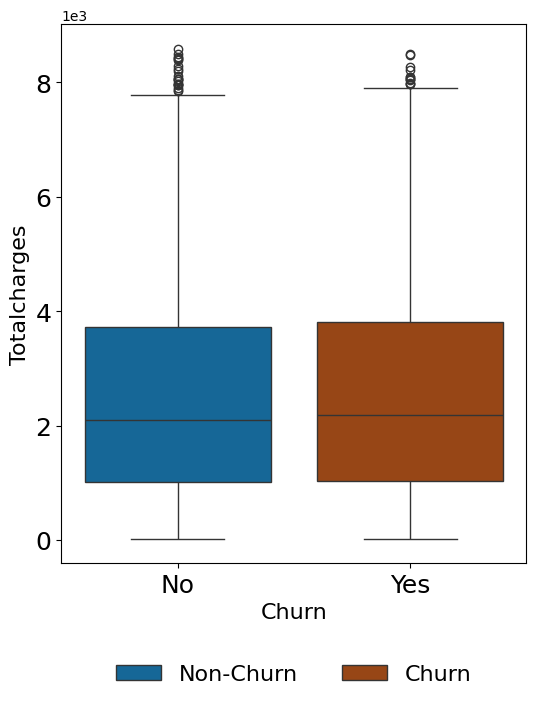

,Class,Q₁,Q₃
0,Non-Churn,1007.5275,3721.3400
1,Churn,1037.9875,3803.1525


In [1845]:
plot_hist_kde(attr_name)
plot_comparison_boxplot(attr_name)

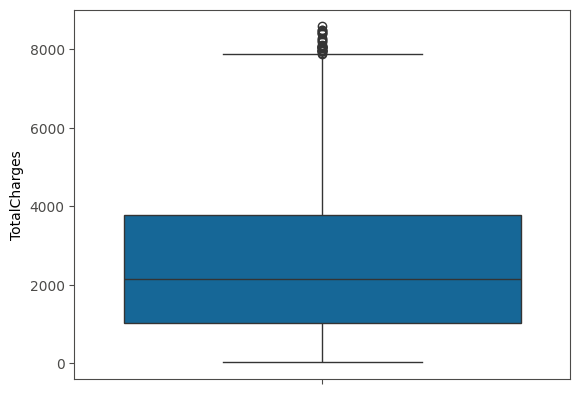

,Statistic,Value
0,Q₁,1020.21750
1,Q₃,3767.66500
2,IQR,2747.44750
3,Lower Bound,-3100.95375
4,Upper Bound,7888.83625


In [1846]:
plot_boxplot(attr_name)

## <font color='#e89c9a'><ul><li>Categorical</li></ul></font>

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Gender</li></ul></font>

In [1847]:
attr_name = 'gender'

In [1848]:
show_categorical_describe(attr_name)

,,Value
0,Unique,2
1,Top,Male
2,Frequency,2950


In [1849]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,Male,2950,1484,1466
1,Female,2930,1498,1432


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Senior Citizen</li></ul></font>

In [1850]:
attr_name = 'SeniorCitizen'

dataset[attr_name] = dataset[attr_name].astype('category')
dataset[attr_name] = dataset[attr_name].cat.rename_categories({0: 'No', 1: 'Yes'})

In [1851]:
show_categorical_describe(attr_name)

,,Value
0,Unique,2
1,Top,Yes
2,Frequency,2944


In [1852]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,No,2936,1482,1454
1,Yes,2944,1500,1444


In [1853]:
# dataset['SeniorCitizen'] = dataset['SeniorCitizen'].map({'No': 0, 'Yes': 1}).astype(int)

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Partner</li></ul></font>

In [1854]:
attr_name = 'Partner'

In [1855]:
show_categorical_describe(attr_name)

,,Value
0,Unique,2
1,Top,Yes
2,Frequency,2995


In [1856]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,No,2885,1478,1407
1,Yes,2995,1504,1491


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Dependents</li></ul></font>

In [1857]:
attr_name = 'Dependents'

In [1858]:
show_categorical_describe(attr_name)

,,Value
0,Unique,2
1,Top,No
2,Frequency,3004


In [1859]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,Yes,2876,1457,1419
1,No,3004,1525,1479


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Phone Service</li></ul></font>

In [1860]:
attr_name = 'PhoneService'

In [1861]:
show_categorical_describe(attr_name)

,,Value
0,Unique,2
1,Top,Yes
2,Frequency,2941


In [1862]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,No,2939,1464,1475
1,Yes,2941,1518,1423


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Multiple Lines</li></ul></font>

In [1863]:
attr_name = 'MultipleLines'

In [1864]:
show_categorical_describe(attr_name)

,,Value
0,Unique,3
1,Top,No phone service
2,Frequency,2939


In [1865]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,No phone service,2939,1464,1475
1,No,1429,737,692
2,Yes,1512,781,731


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Internet Service</li></ul></font>

In [1866]:
attr_name = 'InternetService'

In [1867]:
show_categorical_describe(attr_name)

,,Value
0,Unique,3
1,Top,No
2,Frequency,2029


In [1868]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,No,2029,1021,1008
1,DSL,1936,987,949
2,Fiber optic,1915,974,941


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Online Security</li></ul></font>

In [1869]:
attr_name = 'OnlineSecurity'

In [1870]:
show_categorical_describe(attr_name)

,,Value
0,Unique,3
1,Top,No internet service
2,Frequency,2029


In [1871]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,No internet service,2029,1021,1008
1,Yes,1904,975,929
2,No,1947,986,961


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Online Backup</li></ul></font>

In [1872]:
attr_name = 'OnlineBackup'

In [1873]:
show_categorical_describe(attr_name)

,,Value
0,Unique,3
1,Top,No internet service
2,Frequency,2029


In [1874]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,No internet service,2029,1021,1008
1,No,1986,1024,962
2,Yes,1865,937,928


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Device Protection</li></ul></font>

In [1875]:
attr_name = 'DeviceProtection'

In [1876]:
show_categorical_describe(attr_name)

,,Value
0,Unique,3
1,Top,No internet service
2,Frequency,2029


In [1877]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,No internet service,2029,1021,1008
1,Yes,1926,961,965
2,No,1925,1000,925


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Tech Support</li></ul></font>

In [1878]:
attr_name = 'TechSupport'

In [1879]:
show_categorical_describe(attr_name)

,,Value
0,Unique,3
1,Top,No internet service
2,Frequency,2029


In [1880]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,No internet service,2029,1021,1008
1,No,1932,966,966
2,Yes,1919,995,924


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Streaming TV</li></ul></font>

In [1881]:
attr_name = 'StreamingTV'

In [1882]:
show_categorical_describe(attr_name)

,,Value
0,Unique,3
1,Top,No internet service
2,Frequency,2029


In [1883]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,No internet service,2029,1021,1008
1,Yes,1942,995,947
2,No,1909,966,943


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Streaming Movies</li></ul></font>

In [1884]:
attr_name = 'StreamingMovies'

In [1885]:
show_categorical_describe(attr_name)

,,Value
0,Unique,3
1,Top,No internet service
2,Frequency,2029


In [1886]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,No internet service,2029,1021,1008
1,No,1920,966,954
2,Yes,1931,995,936


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Contract</li></ul></font>

In [1887]:
attr_name = 'Contract'

In [1888]:
show_categorical_describe(attr_name)

,,Value
0,Unique,3
1,Top,Month-to-month
2,Frequency,2020


In [1889]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,Month-to-month,2020,1056,964
1,One year,1954,968,986
2,Two year,1906,958,948


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Paperless Billing</li></ul></font>

In [1890]:
attr_name = 'PaperlessBilling'

In [1891]:
show_categorical_describe(attr_name)

,,Value
0,Unique,2
1,Top,No
2,Frequency,2990


In [1892]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,Yes,2890,1465,1425
1,No,2990,1517,1473


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Payment Method</li></ul></font>

In [1893]:
attr_name = 'PaymentMethod'

In [1894]:
show_categorical_describe(attr_name)

,,Value
0,Unique,4
1,Top,Credit card
2,Frequency,1503


In [1895]:
show_categorical_values(attr_name)

,Name,Total,Non-Churn,Churn
0,Bank transfer,1427,735,692
1,Mailed check,1462,742,720
2,Electronic check,1488,752,736
3,Credit card,1503,753,750


# <font color='#3e9dbf'>Data Preprocess</font>

In [1896]:
preprocessed_dataset = dataset.copy()

In [1897]:
preprocessed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        5880 non-null   object  
 1   gender            5880 non-null   object  
 2   SeniorCitizen     5880 non-null   category
 3   Partner           5880 non-null   object  
 4   Dependents        5880 non-null   object  
 5   tenure            5880 non-null   int64   
 6   PhoneService      5880 non-null   object  
 7   MultipleLines     5880 non-null   object  
 8   InternetService   5880 non-null   object  
 9   OnlineSecurity    5880 non-null   object  
 10  OnlineBackup      5880 non-null   object  
 11  DeviceProtection  5880 non-null   object  
 12  TechSupport       5880 non-null   object  
 13  StreamingTV       5880 non-null   object  
 14  StreamingMovies   5880 non-null   object  
 15  Contract          5880 non-null   object  
 16  PaperlessBilling  5880 n

## <font color='#e89c9a'><ul><li>Combine Columns</li></ul></font>

In [1898]:
def combine_security_service(row):
	unique_values = pd.unique(row)
	if len(unique_values) == 1:
		return unique_values[0]
	elif list(row).count('Yes') >= 2:
		return 'Yes'
	elif list(row).count('No') >= 2:
		return 'No'
	return ','.join(unique_values)

preprocessed_dataset['SecurityService'] = preprocessed_dataset[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection']].apply(combine_security_service, axis=1)

In [1899]:
show_categorical_values('SecurityService', preprocessed_dataset)

,Name,Total,Non-Churn,Churn
0,No internet service,2029,1021,1008
1,Yes,1891,953,938
2,No,1960,1008,952


## <font color='#e89c9a'><ul><li>Drop Feature</li></ul></font>

In [1900]:
preprocessed_dataset.drop(columns=['customerID', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection'], inplace=True)
preprocessed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            5880 non-null   object  
 1   SeniorCitizen     5880 non-null   category
 2   Partner           5880 non-null   object  
 3   Dependents        5880 non-null   object  
 4   tenure            5880 non-null   int64   
 5   PhoneService      5880 non-null   object  
 6   MultipleLines     5880 non-null   object  
 7   InternetService   5880 non-null   object  
 8   TechSupport       5880 non-null   object  
 9   StreamingTV       5880 non-null   object  
 10  StreamingMovies   5880 non-null   object  
 11  Contract          5880 non-null   object  
 12  PaperlessBilling  5880 non-null   object  
 13  PaymentMethod     5880 non-null   object  
 14  MonthlyCharges    5880 non-null   float64 
 15  TotalCharges      5880 non-null   float64 
 16  Churn             5880 n

## <font color='#e89c9a'><ul><li>Handling Outliers</li></ul></font>

In [1901]:
def plot_outliers_boxplot(dataset, attr_name, color):
  plt.figure(figsize=(3, 7))
  sns.boxplot(data=dataset[attr_name], color=color, orient='v')
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.gca().set_facecolor("none")
  plt.gcf().set_facecolor("none")
  plt.show()

  Q1 = dataset[attr_name].quantile(0.25)
  Q3 = dataset[attr_name].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  bounds_table = pd.DataFrame({
    'Statistic': ['Q₁', 'Q₃', 'IQR', 'Lower Bound', 'Upper Bound'],
    'Value': [Q1, Q3, IQR, lower_bound, upper_bound]
  })

  return bounds_table

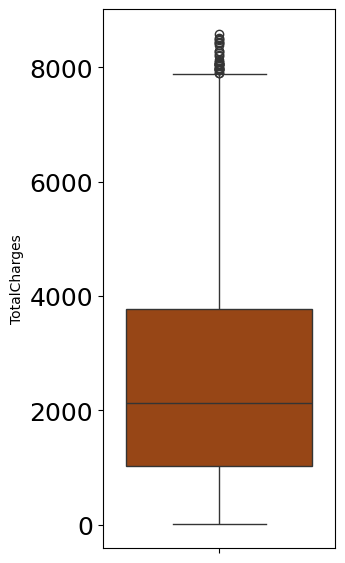

,Statistic,Value
0,Q₁,1020.21750
1,Q₃,3767.66500
2,IQR,2747.44750
3,Lower Bound,-3100.95375
4,Upper Bound,7888.83625


In [1902]:
plot_outliers_boxplot(preprocessed_dataset, 'TotalCharges', '#ad4000')

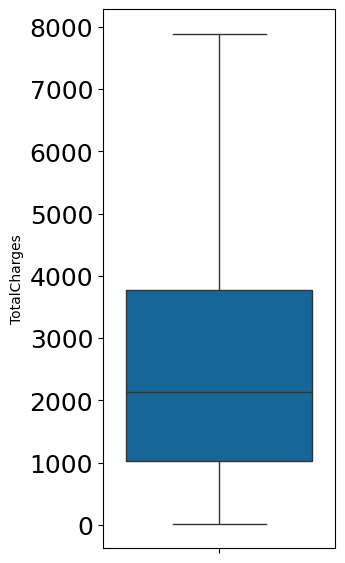

,Statistic,Value
0,Q₁,1020.21750
1,Q₃,3767.66500
2,IQR,2747.44750
3,Lower Bound,-3100.95375
4,Upper Bound,7888.83625


In [1903]:
preprocessed_dataset['TotalCharges'] = preprocessed_dataset['TotalCharges'].clip(lower=-3100.95375, upper=7888.83625)
plot_outliers_boxplot(preprocessed_dataset, 'TotalCharges', '#006dad')

## <font color='#e89c9a'><ul><li>Feature Encoding</li></ul></font>

In [1904]:
preprocessed_dataset = pd.get_dummies(preprocessed_dataset, drop_first=True)

preprocessed_dataset.rename(columns={"SeniorCitizen_Yes": "SeniorCitizen"}, inplace=True)
preprocessed_dataset.rename(columns={"Partner_Yes": "Partner"}, inplace=True)
preprocessed_dataset.rename(columns={"Dependents_Yes": "Dependents"}, inplace=True)
preprocessed_dataset.rename(columns={"PhoneService_Yes": "PhoneService"}, inplace=True)
preprocessed_dataset.rename(columns={"PaperlessBilling_Yes": "PaperlessBilling"}, inplace=True)
preprocessed_dataset.rename(columns={"Churn_Yes": "Churn"}, inplace=True)

In [1905]:
preprocessed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   tenure                               5880 non-null   int64  
 1   MonthlyCharges                       5880 non-null   float64
 2   TotalCharges                         5880 non-null   float64
 3   gender_Male                          5880 non-null   bool   
 4   SeniorCitizen                        5880 non-null   bool   
 5   Partner                              5880 non-null   bool   
 6   Dependents                           5880 non-null   bool   
 7   PhoneService                         5880 non-null   bool   
 8   MultipleLines_No phone service       5880 non-null   bool   
 9   MultipleLines_Yes                    5880 non-null   bool   
 10  InternetService_Fiber optic          5880 non-null   bool   
 11  InternetService_No            

In [1906]:
preprocessed_dataset.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,SecurityService_No internet service,SecurityService_Yes
0,23,49.85,1146.55,True,False,False,True,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1,43,100.70,4330.10,False,False,True,False,False,True,False,...,False,False,False,False,False,False,True,True,False,True
2,51,97.33,4963.83,True,True,False,False,True,False,False,...,False,True,False,False,False,True,False,True,False,True
3,72,101.38,7299.36,True,True,False,False,True,False,True,...,False,False,False,False,True,False,False,False,False,True
4,25,52.22,1305.50,True,True,False,False,True,False,True,...,True,False,False,False,False,True,False,True,False,False


## <font color='#e89c9a'><ul><li>Feature Scaling</li></ul></font>

In [1907]:
selected_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
num_dataframe = preprocessed_dataset[selected_columns]
num_dataframe.head(len(preprocessed_dataset))

,tenure,MonthlyCharges,TotalCharges
0,23,49.85,1146.55
1,43,100.70,4330.10
2,51,97.33,4963.83
3,72,101.38,7299.36
4,25,52.22,1305.50
...,...,...,...
5875,71,74.21,5268.91
5876,22,65.43,1439.46
5877,68,59.78,4065.04
5878,14,91.88,1286.32


In [1908]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
preprocessed_dataset[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(preprocessed_dataset[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [1909]:
num_dataframe = preprocessed_dataset[selected_columns]
num_dataframe.head(len(preprocessed_dataset))

,tenure,MonthlyCharges,TotalCharges
0,0.309859,0.298530,0.143163
1,0.591549,0.807081,0.547741
2,0.704225,0.773377,0.628278
3,1.000000,0.813881,0.925087
4,0.338028,0.322232,0.163363
...,...,...,...
5875,0.985915,0.542154,0.667049
5876,0.295775,0.454345,0.180387
5877,0.943662,0.397840,0.514056
5878,0.183099,0.718872,0.160925


## <font color='#e89c9a'><ul><li>Spilt Train and Test Data</li></ul></font>

In [1910]:
x = preprocessed_dataset.copy().drop(columns=['Churn'])
y = preprocessed_dataset['Churn']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [1911]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   tenure                               5880 non-null   float64
 1   MonthlyCharges                       5880 non-null   float64
 2   TotalCharges                         5880 non-null   float64
 3   gender_Male                          5880 non-null   bool   
 4   SeniorCitizen                        5880 non-null   bool   
 5   Partner                              5880 non-null   bool   
 6   Dependents                           5880 non-null   bool   
 7   PhoneService                         5880 non-null   bool   
 8   MultipleLines_No phone service       5880 non-null   bool   
 9   MultipleLines_Yes                    5880 non-null   bool   
 10  InternetService_Fiber optic          5880 non-null   bool   
 11  InternetService_No            

In [1912]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5880 entries, 0 to 5879
Series name: Churn
Non-Null Count  Dtype
--------------  -----
5880 non-null   bool 
dtypes: bool(1)
memory usage: 5.9 KB


In [1913]:
pd.DataFrame({
	'Train': [sum(y_train), len(y_train) - sum(y_train), y_train.shape[0]],
	'Test': [sum(y_test), len(y_test) - sum(y_test), y_test.shape[0]],
}, index=['Churn', 'Non-Churn', 'Total'])

,Train,Test
Churn,2008,890
Non-Churn,2108,874
Total,4116,1764


# <font color='#3e9dbf'>K Nearest Neighbors (KNN) Classifier</font>

In [1914]:
from sklearn.neighbors import KNeighborsClassifier

## <font color='#e89c9a'><ul><li>Plot KNN Error rate</li></ul></font>

In [1915]:
def plot_knn_error_rate(train_x, train_y, test_x, test_y):
	error = []
	minError = (1, 0)
	maxError = (1, 0)

	for i in range(1, 50):
		knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
		knn.fit(train_x, train_y)
		pred_i = knn.predict(test_x)
		error_rate = np.mean(pred_i != test_y)
		error.append(error_rate)

		if error_rate < minError[1] or minError == (1, 0):
			minError = (i, error_rate)
		if error_rate > maxError[1]:
			maxError = (i, error_rate)
	
	plt.figure(figsize=(15, 8))
	plt.plot(range(1, 50), error, color='#1178be', linestyle='dashed', marker='o', markerfacecolor='#1178be', markersize=15)
	plt.xlabel('K Value', fontsize=20) 
	plt.ylabel('Mean Error', fontsize=20)
	plt.xticks(fontsize=18)
	plt.yticks(fontsize=18)
	plt.grid(True)
	plt.show()

	knn_error_table = pd.DataFrame({
		'K Value': [minError[0], maxError[0]],
		'Mean Error': [round(minError[1], 3), round(maxError[1], 3)],
	}, index=['Min', 'Max'])

	return knn_error_table, minError[0]

## <font color='#e89c9a'><ul><li>Without PCA</li></ul></font>

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Train Model</li></ul></font>

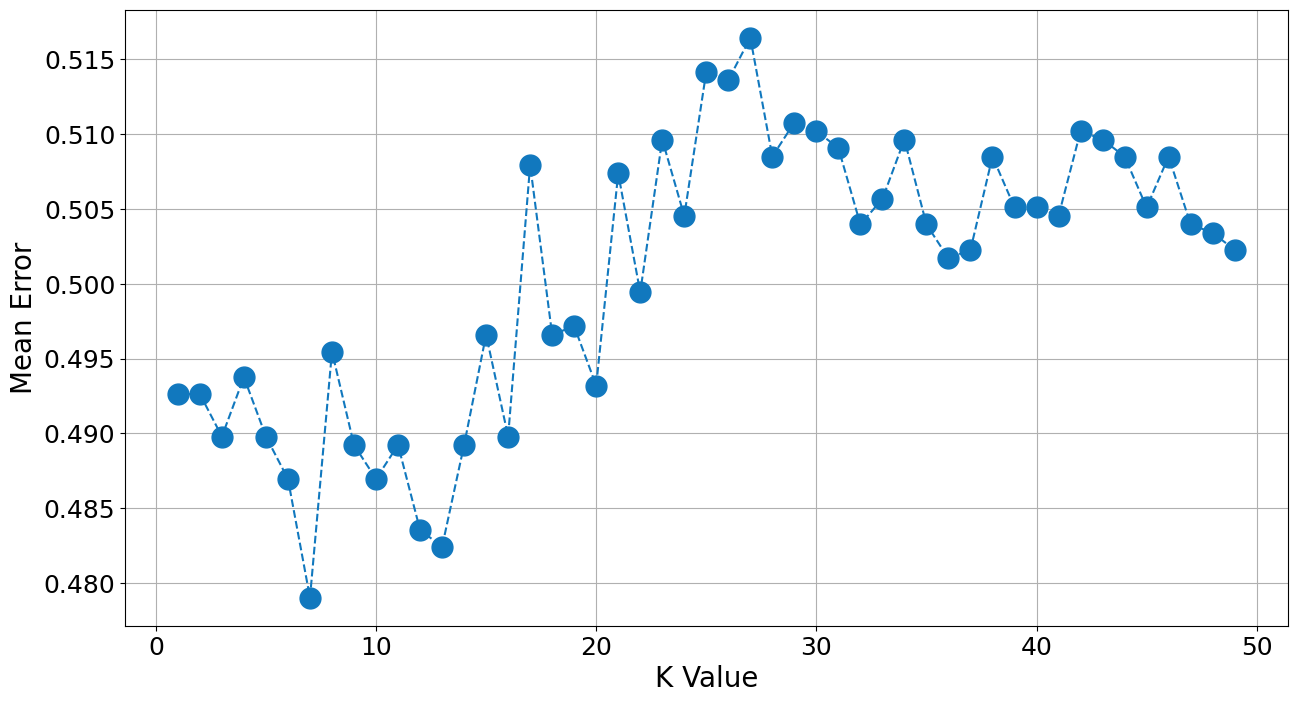

In [1916]:
table, k_value = plot_knn_error_rate(x_train, y_train, x_test, y_test)

In [1917]:
table.head()

,K Value,Mean Error
Min,7,0.479
Max,27,0.516


In [1918]:
knn_model = KNeighborsClassifier(n_neighbors=k_value, weights='distance')
history = knn_model.fit(x_train, y_train)

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Train predict</li></ul></font>

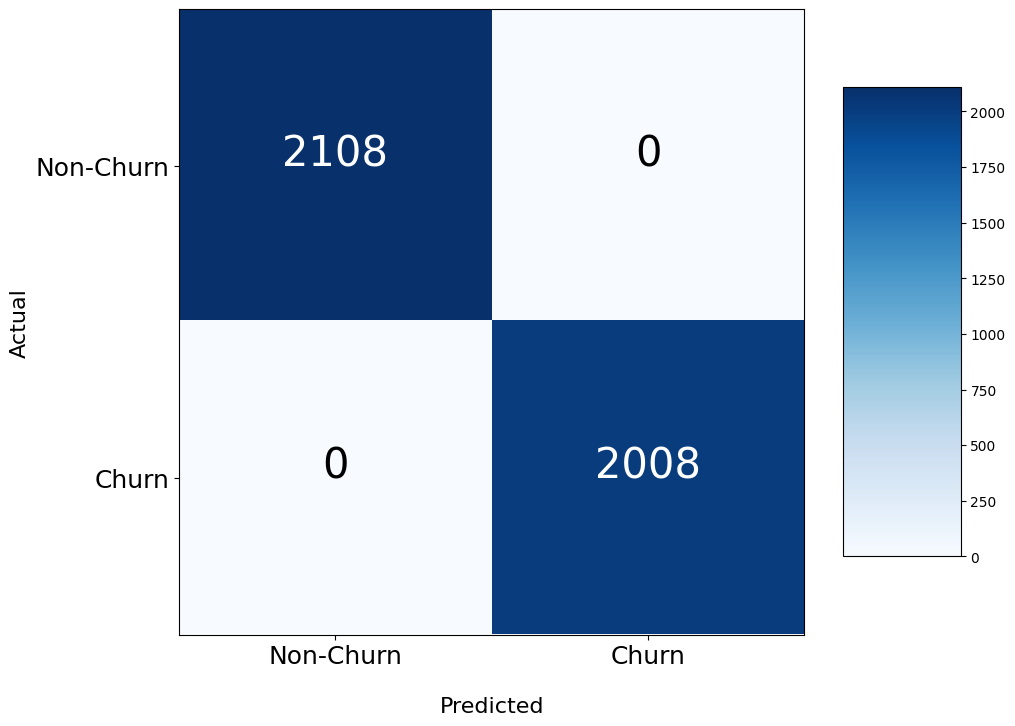

Accuracy: 100.00%


In [1919]:
# Confusion matrix
y_pred = knn_model.predict(x_train)
cm = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(cm)

# Accuracy
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Test predict</li></ul></font>

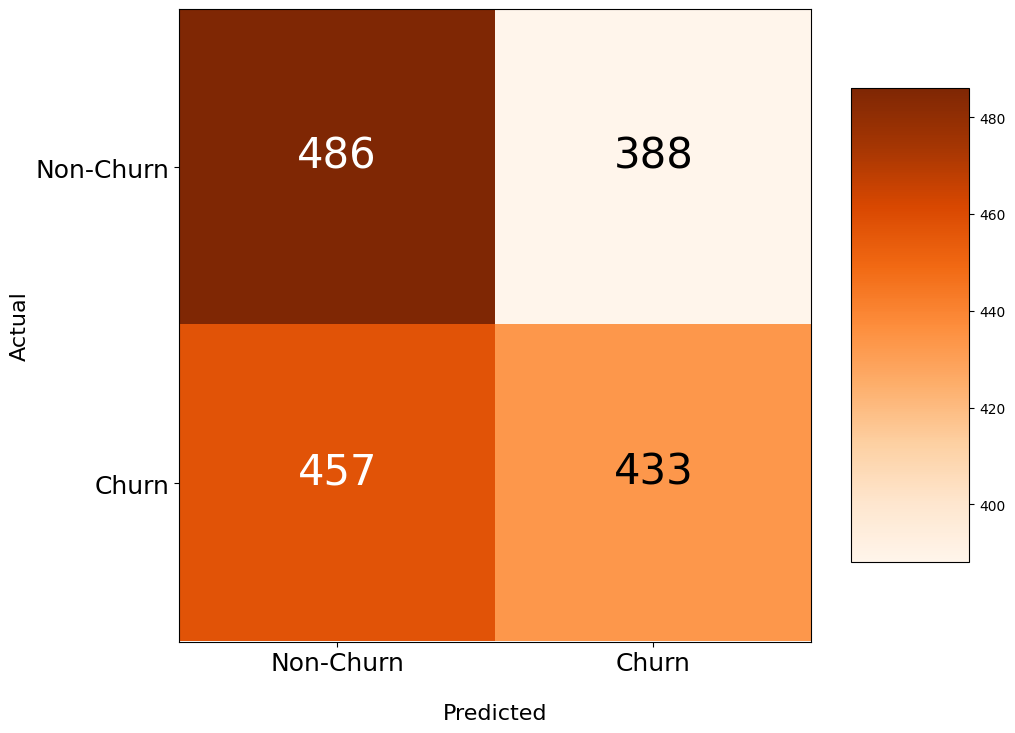

Accuracy: 52.10%


In [1920]:
# Confusion matrix
y_pred = knn_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, color='orange')

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Learning curve</li></ul></font>

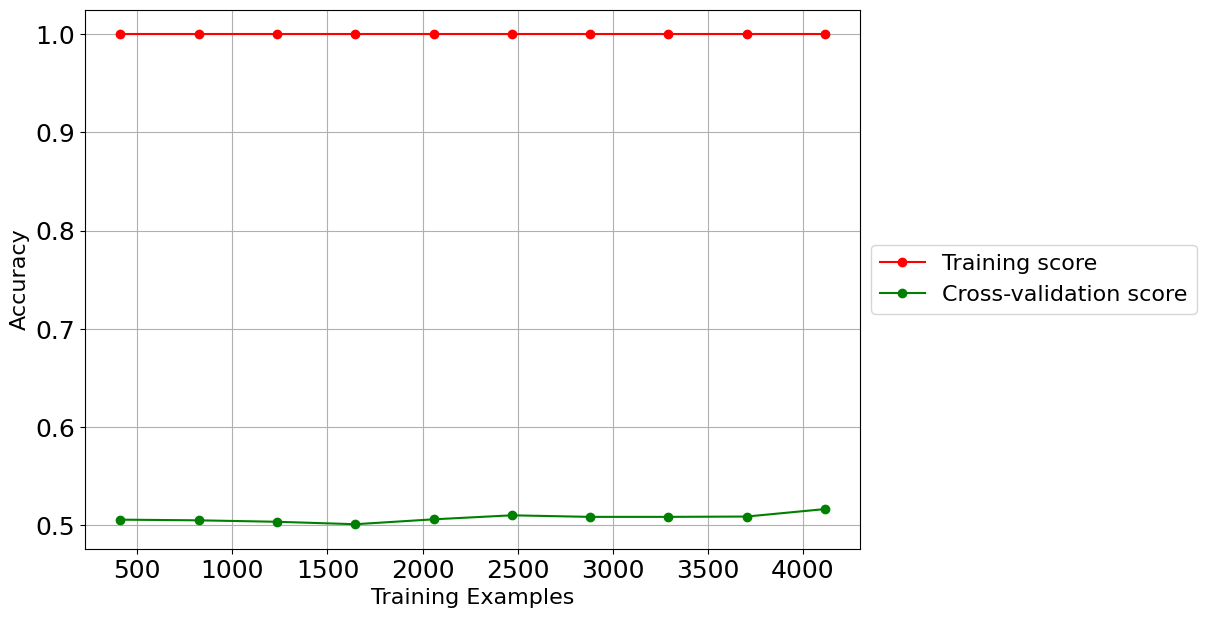

In [1921]:
plot_learning_curve(knn_model, x, y)

## <font color='#e89c9a'><ul><li>With PCA</li></ul></font>

In [1922]:
from sklearn.decomposition import PCA

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>PCA Error Rate</li></ul></font>

In [1923]:
k_value

7

In [1924]:
error = []
minError = (1, 0)
maxError = (1, 0)

for i in range(1, x.shape[1] + 1):

	pca = PCA(n_components=i, random_state=42)
	x_pca = pca.fit_transform(x)

	x_pca_train, x_pca_test, y_pca_train, y_pca_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)

	knn = KNeighborsClassifier(weights='distance')
	knn.fit(x_pca_train, y_pca_train)
	pred_i = knn.predict(x_pca_test)
	error_rate = np.mean(pred_i != y_pca_test)
	error.append(error_rate)

	if error_rate < minError[1] or minError == (1, 0):
		minError = (i, error_rate)
	if error_rate > maxError[1]:
		maxError = (i, error_rate)

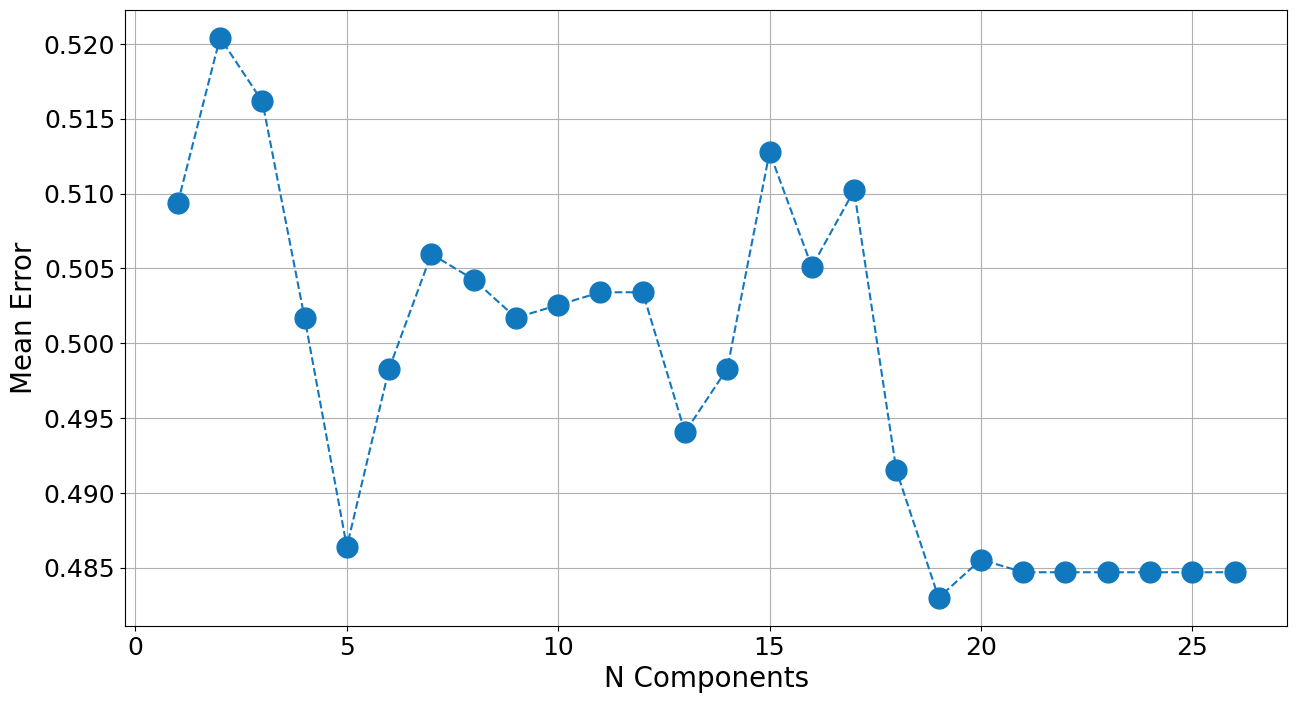

In [1925]:
plt.figure(figsize=(15, 8))
plt.plot(range(1, x.shape[1] + 1), error, color='#1178be', linestyle='dashed', marker='o', markerfacecolor='#1178be', markersize=15)
plt.xlabel('N Components', fontsize=20) 
plt.ylabel('Mean Error', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

In [1926]:
pd.DataFrame({
	'N Components': [minError[0], maxError[0]],
	'Mean Error': [round(minError[1], 3), round(maxError[1], 3)],
}, index=['Min', 'Max']).head()

,N Components,Mean Error
Min,19,0.483
Max,2,0.520


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Split Data</li></ul></font>

In [1927]:
pca = PCA(n_components=minError[0], random_state=42) 
x_pca = pca.fit_transform(x)
x_pca_train, x_pca_test, y_pca_train, y_pca_test = train_test_split(x_pca, y, test_size=0.3, random_state=42)

In [1928]:
pd.DataFrame({
	'Train': [sum(y_pca_train), len(y_pca_train) - sum(y_pca_train), y_pca_train.shape[0]],
	'Test': [sum(y_pca_test), len(y_pca_test) - sum(y_pca_test), y_pca_test.shape[0]],
}, index=['Churn', 'Non-Churn', 'Total'])

,Train,Test
Churn,2008,890
Non-Churn,2108,874
Total,4116,1764


### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Train Model</li></ul></font>

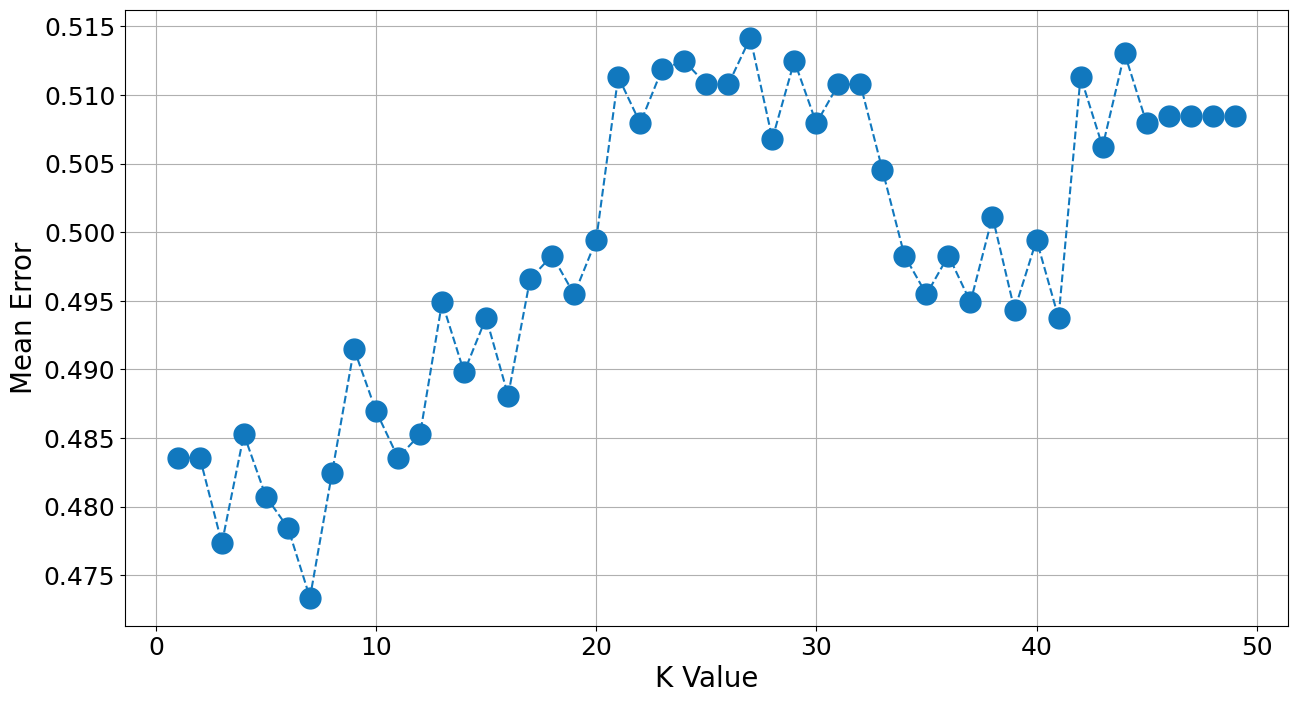

In [1929]:
table, k_value = plot_knn_error_rate(x_pca_train, y_pca_train, x_pca_test, y_pca_test)

In [1930]:
table.head()

,K Value,Mean Error
Min,7,0.473
Max,27,0.514


In [1931]:
knn_pca_model = KNeighborsClassifier(n_neighbors=k_value, weights='distance')
knn_pca_model.fit(x_pca_train, y_pca_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Train predict</li></ul></font>

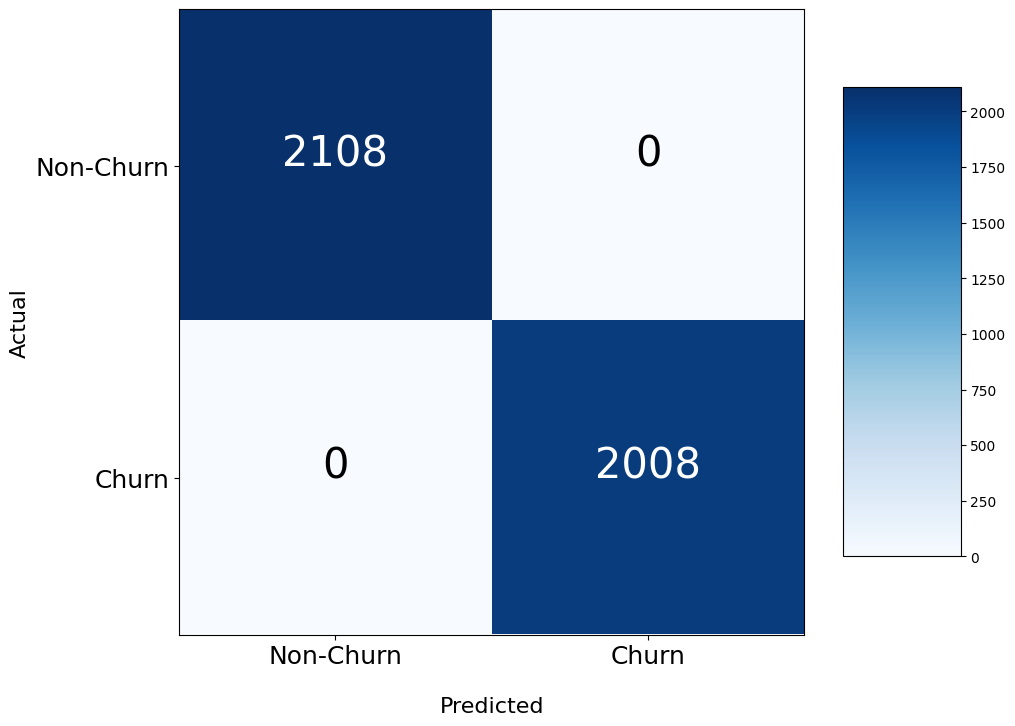

Accuracy: 100.00%


In [1932]:
# Confusion matrix
y_pca_pred = knn_pca_model.predict(x_pca_train)
cm = confusion_matrix(y_pca_train, y_pca_pred)
plot_confusion_matrix(cm)

# Accuracy
accuracy = accuracy_score(y_pca_train, y_pca_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Test predict</li></ul></font>

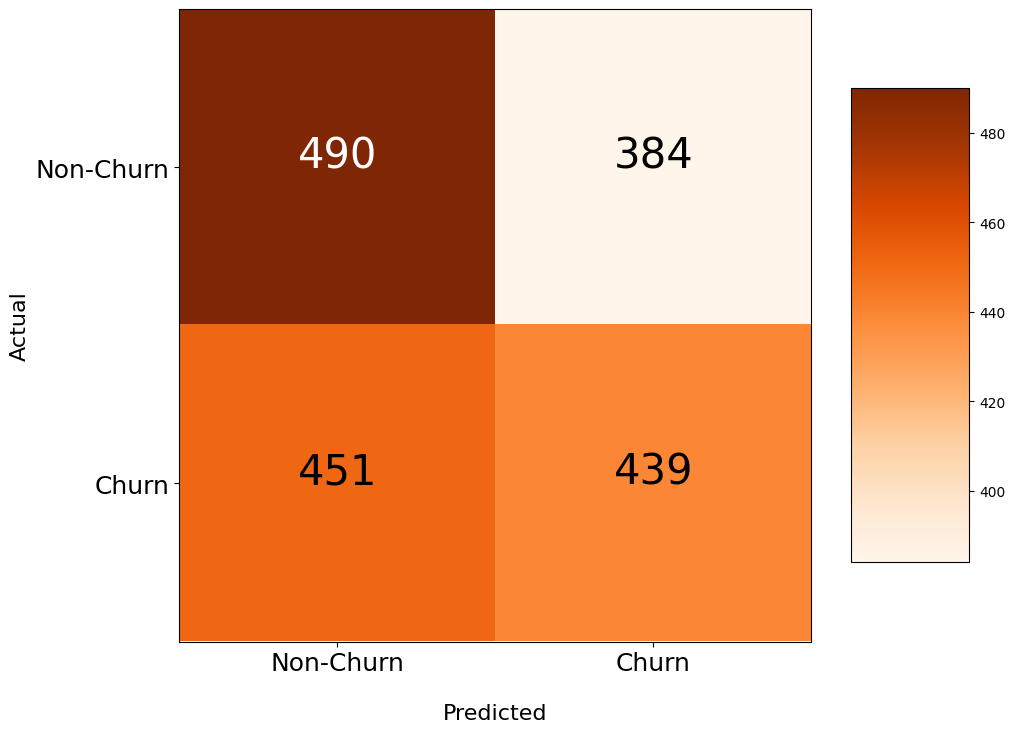

Accuracy: 52.66%


In [1933]:
# Confusion matrix
y_pca_pred = knn_pca_model.predict(x_pca_test)
cm = confusion_matrix(y_pca_test, y_pca_pred)
plot_confusion_matrix(cm, color='orange')

# Accuracy
accuracy = accuracy_score(y_pca_test, y_pca_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Learning curve</li></ul></font>

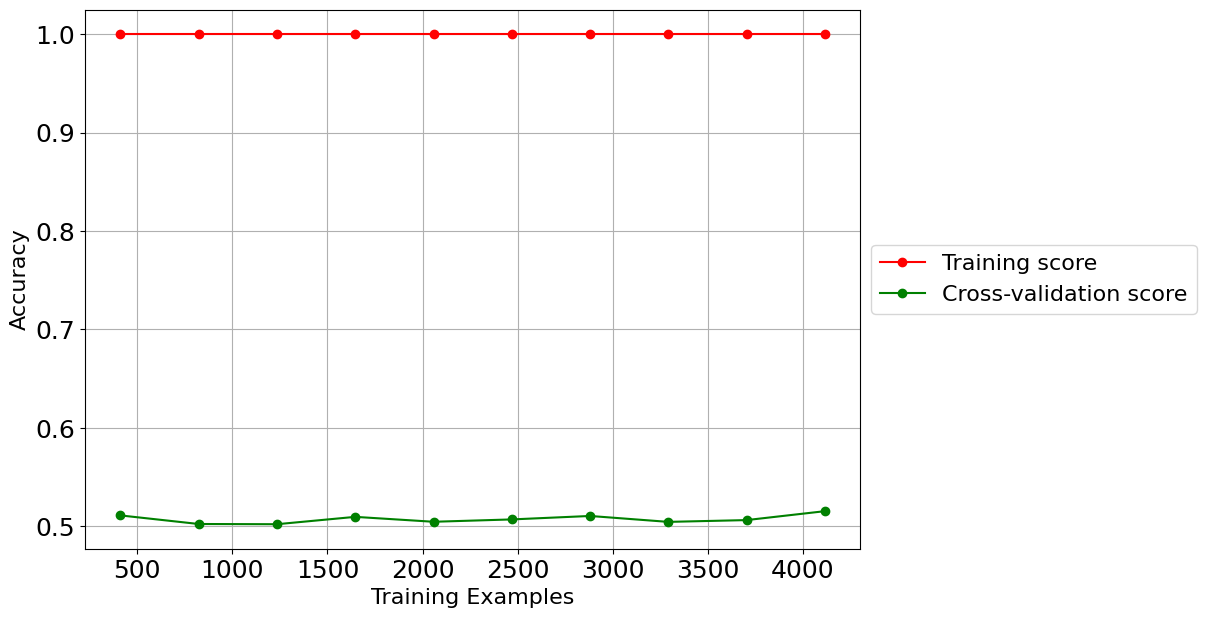

In [1934]:
plot_learning_curve(knn_pca_model, x_pca, y)

# <font color='#3e9dbf'>K Means Clustering</font>

In [1935]:
from sklearn.cluster import KMeans

In [1936]:
def plot_clusters(x, y, model):
	plt.figure(figsize=(10, 8))
	label_0 = x[y == 0]
	label_1 = x[y == 1]

	plt.scatter(label_0.iloc[:, 0], label_0.iloc[:, 1], c='#006dad', s=50, alpha=0.6, label='Non-Churn')
	plt.scatter(label_1.iloc[:, 0], label_1.iloc[:, 1], c='#ad4000', s=50, alpha=0.6, label='Churn')
	plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='black', s=200, marker='X', label='Centroids')
	plt.xticks(fontsize=18)
	plt.yticks(fontsize=18)
	plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
	plt.grid(True)
	plt.show()

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Train Model</li></ul></font>

In [1937]:
k_means_model = KMeans(n_clusters=2, random_state=42)
k_means_model.fit(x_train)

KMeans(n_clusters=2, random_state=42)

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Train predict</li></ul></font>

In [1938]:
y_k_means = k_means_model.predict(x_train)

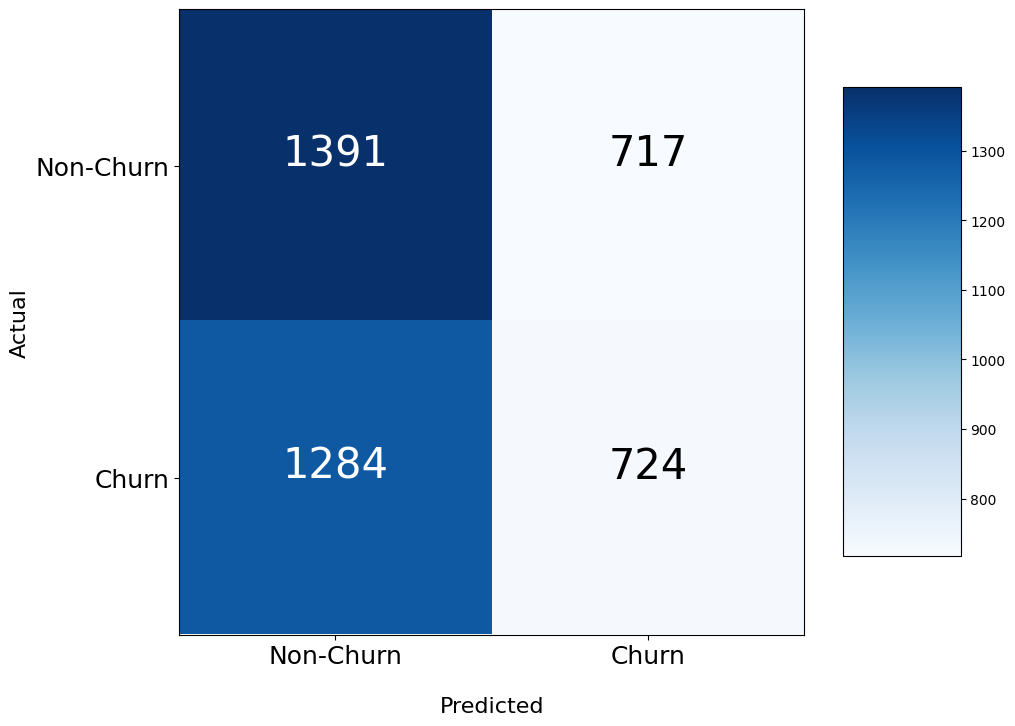

In [1939]:
if np.sum(y_train == y_k_means) < np.sum(y_train == 1 - y_k_means):
	y_k_means = 1 - y_k_means

cm = confusion_matrix(y_train, y_k_means)
plot_confusion_matrix(cm)

In [1940]:
accuracy = accuracy_score(y_train, y_k_means)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 51.38%


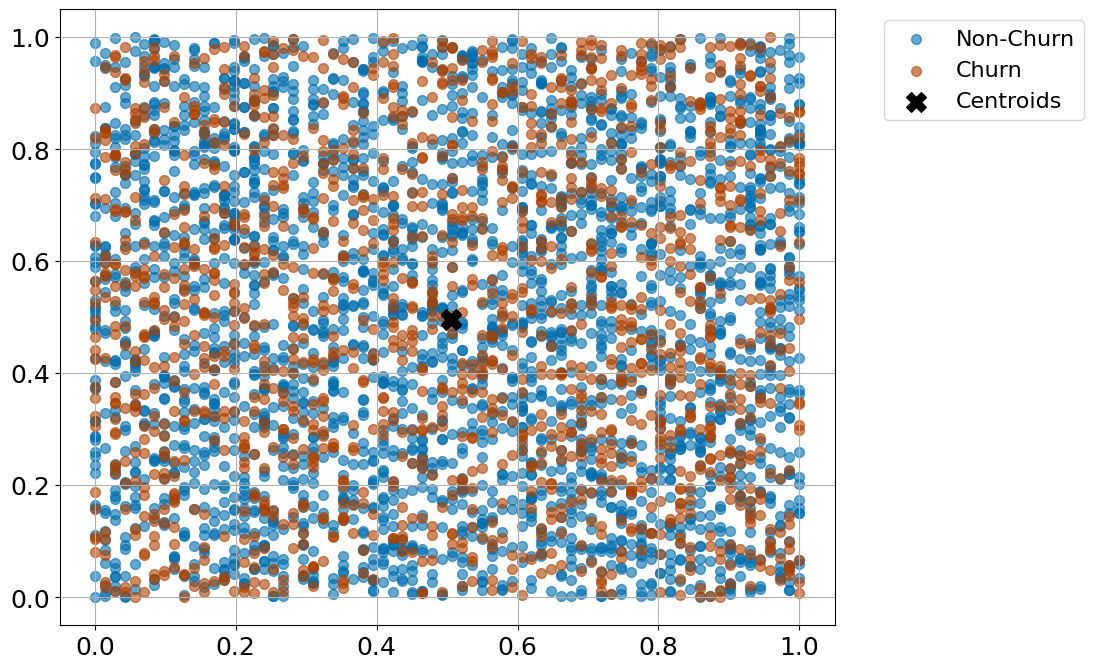

In [1941]:
plot_clusters(x_train, y_k_means, k_means_model)

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Test predict</li></ul></font>

In [1942]:
y_k_means = k_means_model.predict(x_test)

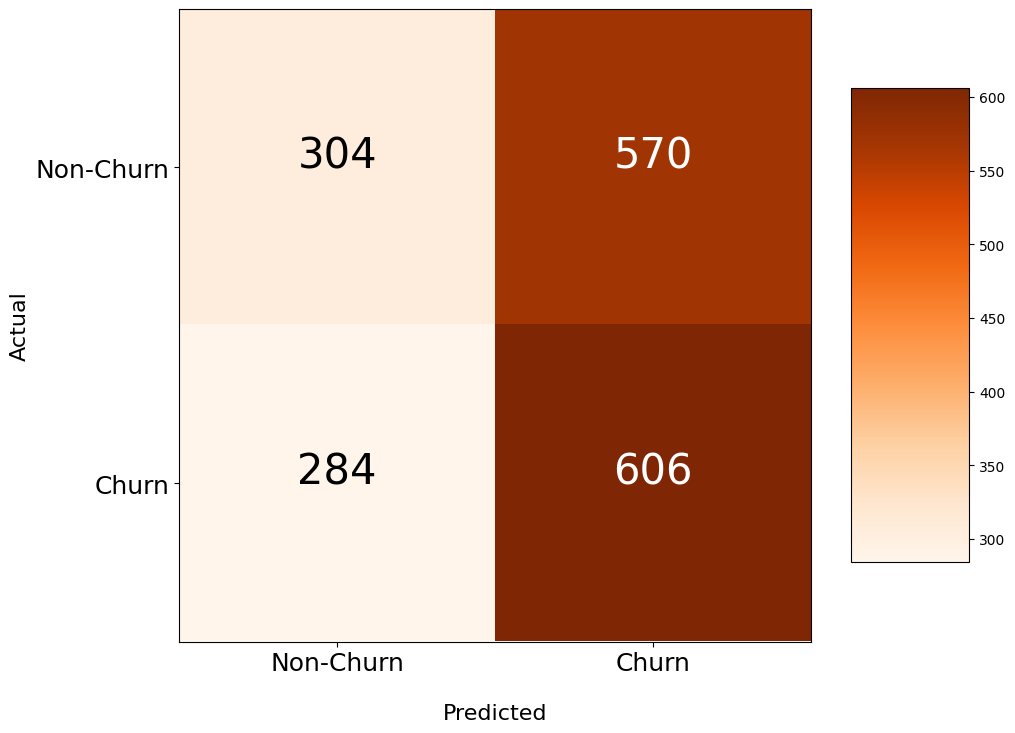

In [1943]:
if np.sum(y_test == y_k_means) < np.sum(y_test == 1 - y_k_means):
	y_k_means = 1 - y_k_means

cm = confusion_matrix(y_test, y_k_means)
plot_confusion_matrix(cm, color='orange')

In [1944]:
accuracy = accuracy_score(y_test, y_k_means)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 51.59%


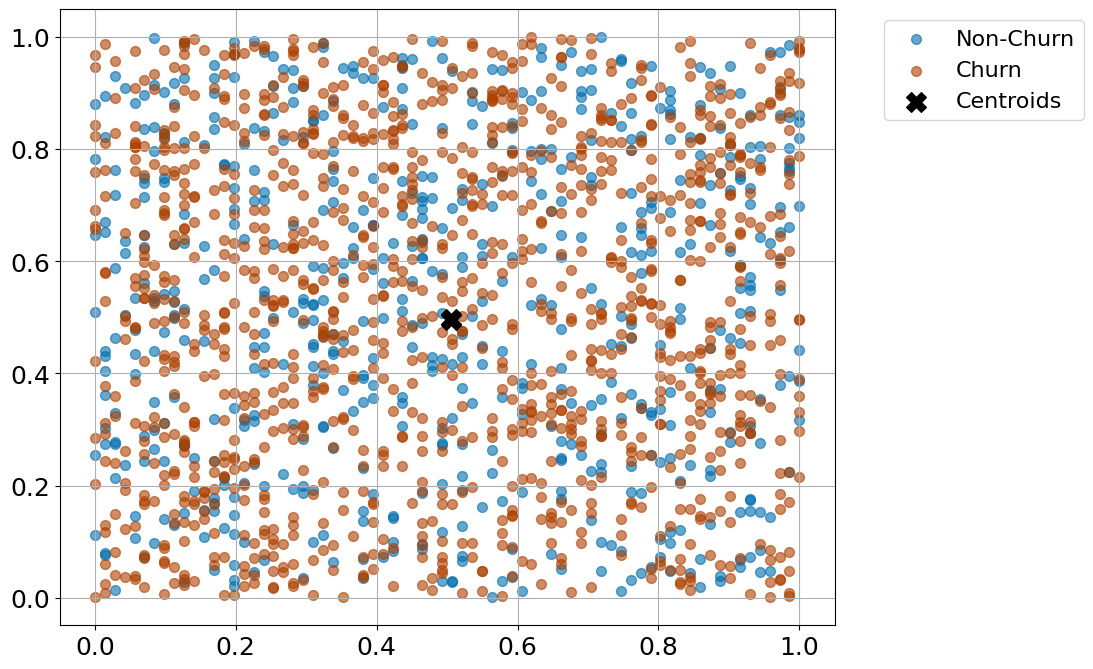

In [1945]:
plot_clusters(x_test, y_k_means, k_means_model)

### <font color='#9ae89c'><ul style="list-style-type:circle;"><li>Learning curve</li></ul></font>

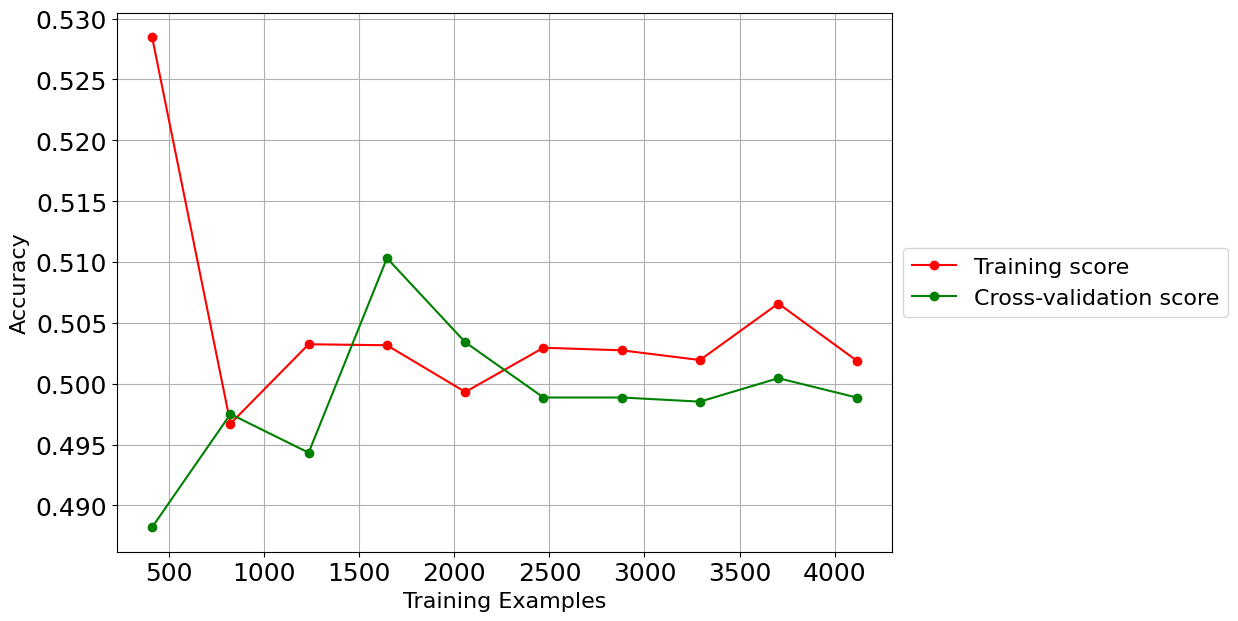

In [1946]:
plot_learning_curve(k_means_model, x, y)